In [1]:
import os
import numpy
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, fftfreq
import matplotlib
%matplotlib inline
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import signal
import scipy.io as sp
import pickle
import time
import glob
from netCDF4 import Dataset
from PyEMD import EMD, Visualisation
from datetime import datetime, date, time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
tide_dir = '/media/drfab/data/marée/conquet/'
tide_path = os.path.join(tide_dir, '3_2020.nc')
dset = Dataset(tide_path, 'r')
tide_t = dset.variables['TIME'][:]
tide_height = dset.variables['Source4'][:]
dset.close()

delta = 4.055  #conquet
delta = 4.2125  #brest

w = numpy.where(tide_height > 0)
# emd = EMD()
# emd.emd(tide_height[w])
# imfs, res = emd.get_imfs_and_residue()
# emds = imfs[3:11].sum(axis=0)

fig = plt.figure(figsize=(26,10))
# plt.plot(emds,'.')
sl = (tide_height[1:-1]-tide_height[0:-2])/(tide_t[1:-1]-tide_t[0:-2])
th = (tide_height[1:-1]+tide_height[0:-2])/2.
ph = np.angle(signal.hilbert(th-delta))
amp = np.abs(signal.hilbert(th-delta))
tide_time = (tide_t[1:-1]+tide_t[0:-2])/2.


<ipython-input-3-33c3cc723aa5>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tide_t = dset.variables['TIME'][:]
<ipython-input-3-33c3cc723aa5>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tide_height = dset.variables['Source4'][:]


<Figure size 1872x720 with 0 Axes>

<ipython-input-7-033efad1f27c>:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if ((numpy.int(time) < 120000) & (np.abs(np.angle(np.exp(1j*(ph[wtide]-tph))))<(2*np.pi/nstep)) & (amp[wtide]<20) & (abs(tide_time[wtide]-(t.total_seconds()/3600))<1)) :


9.0
6.0
5.0
6.0
13.0
18.0
12.0
15.0
14.0
8.0
8.0
8.0


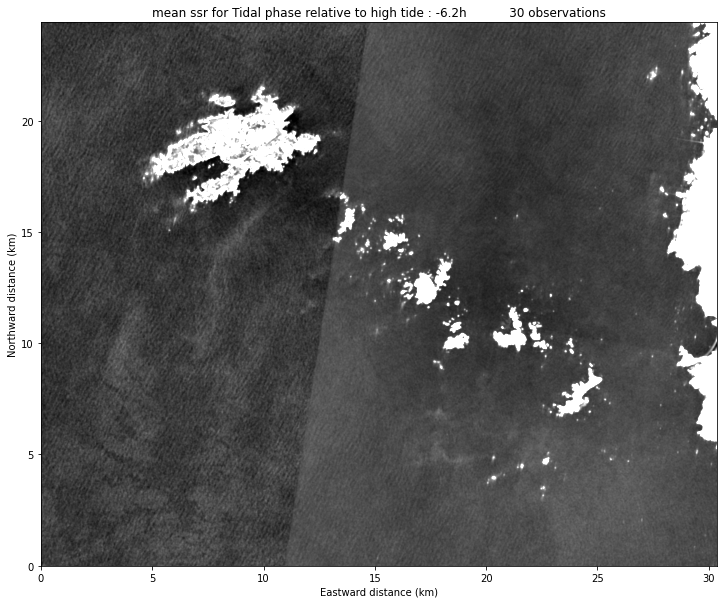

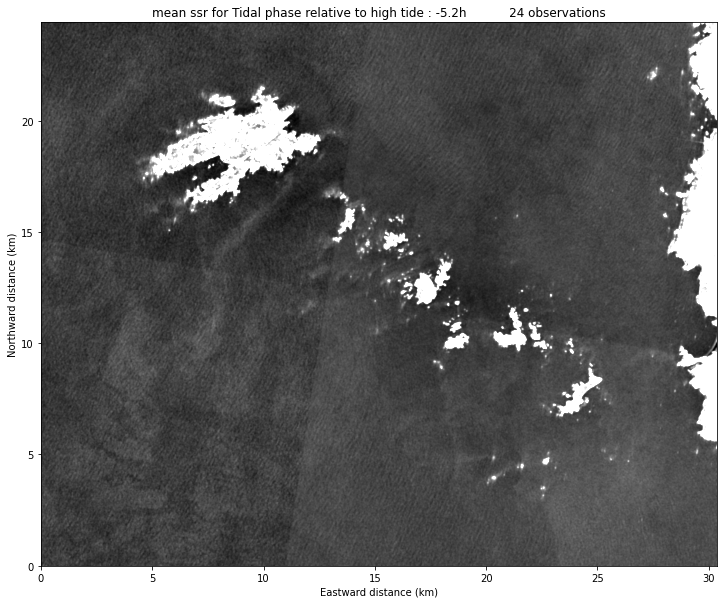

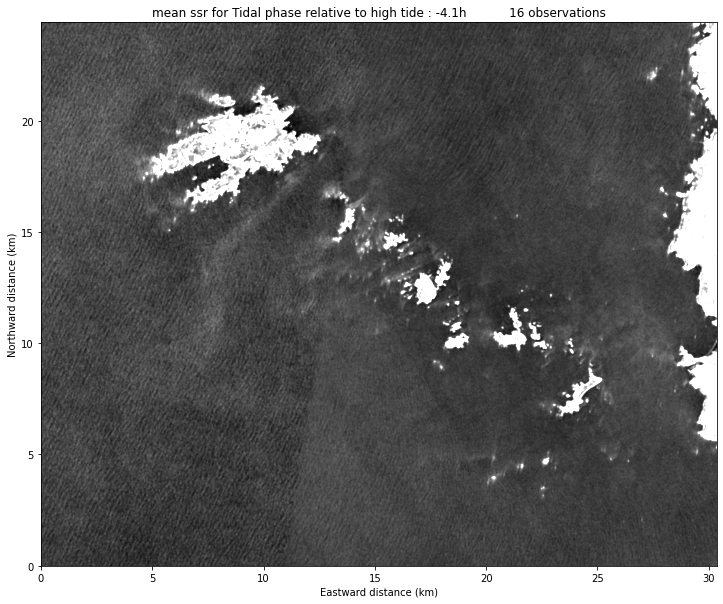

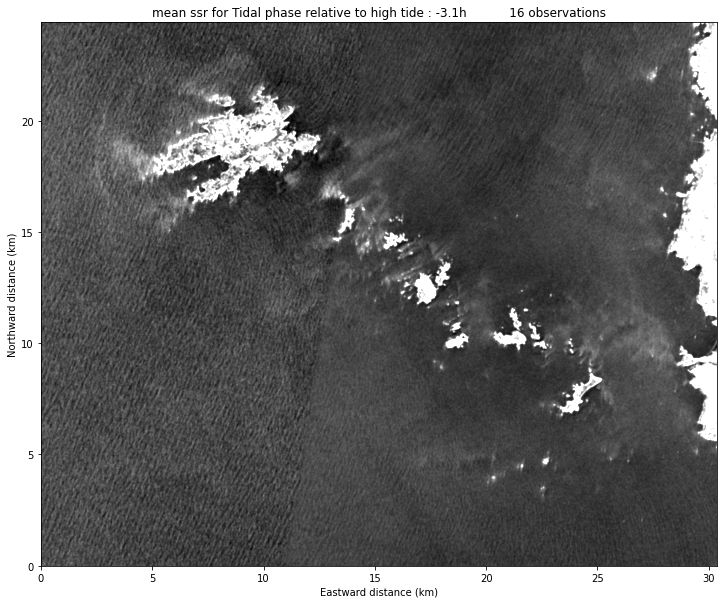

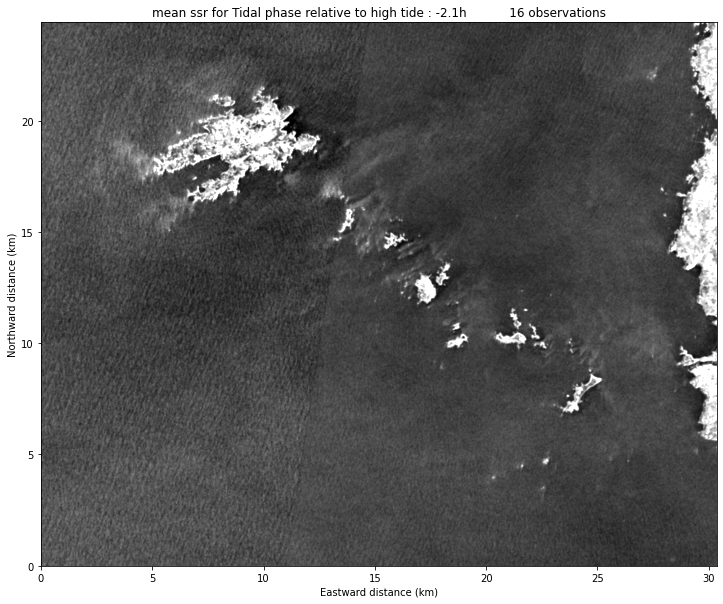

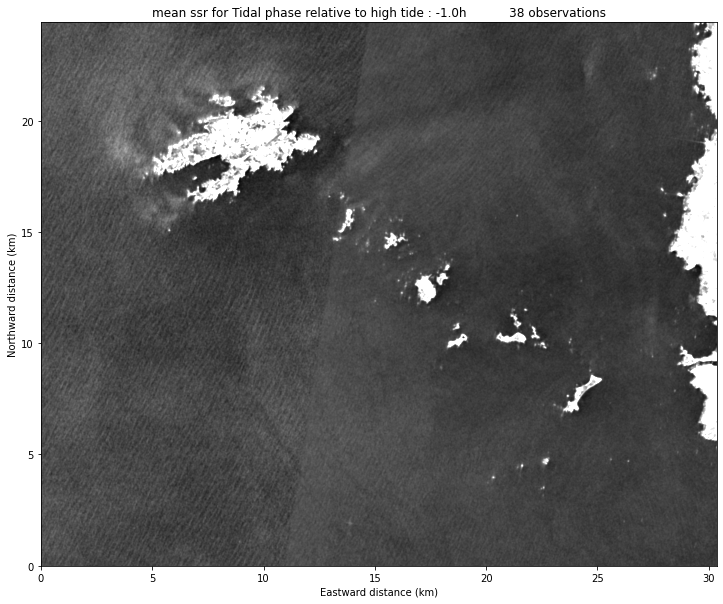

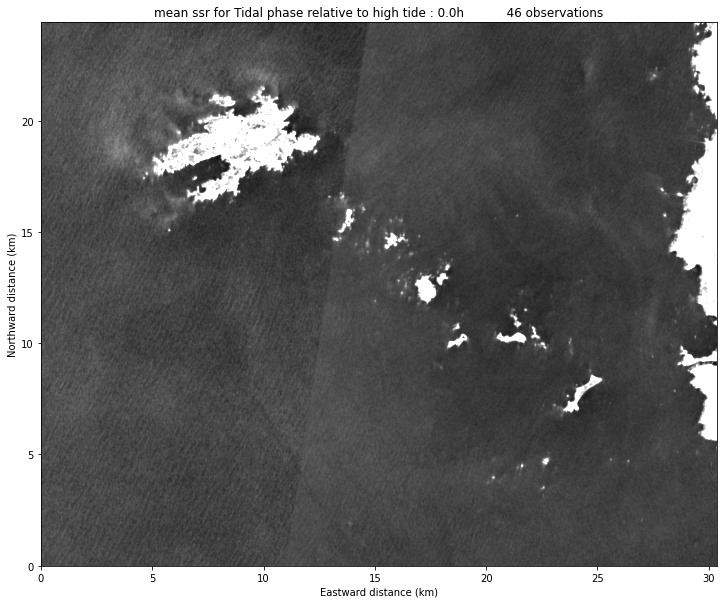

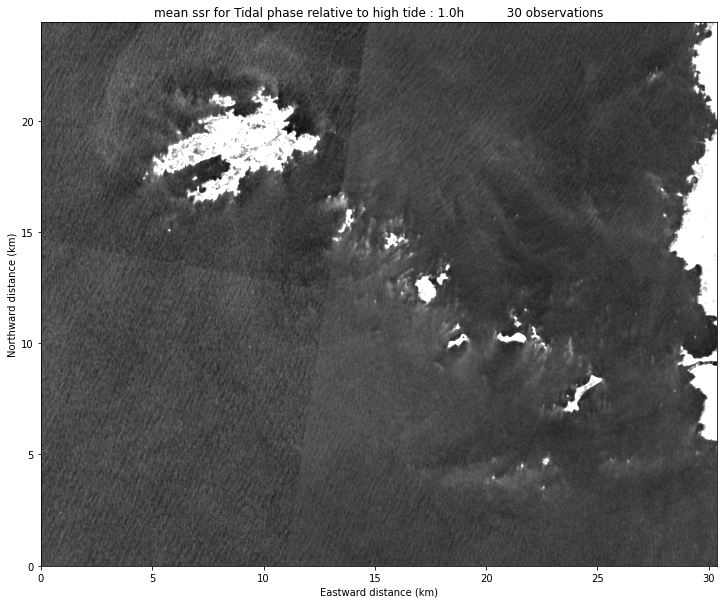

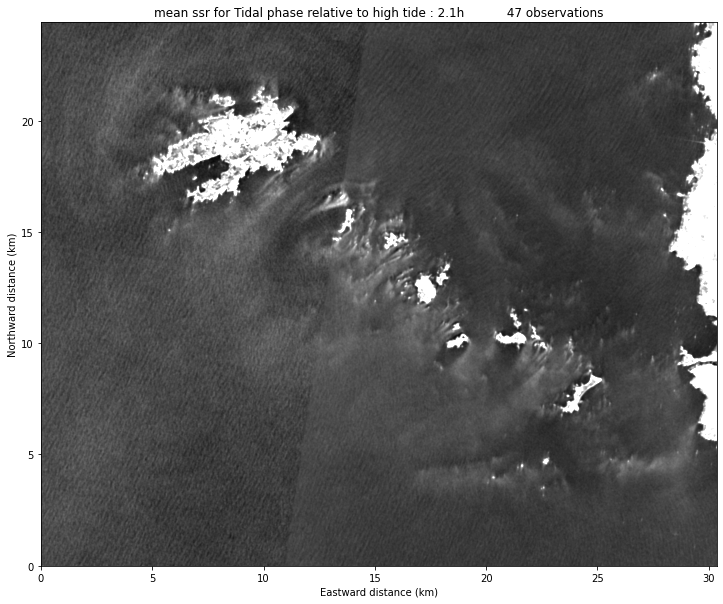

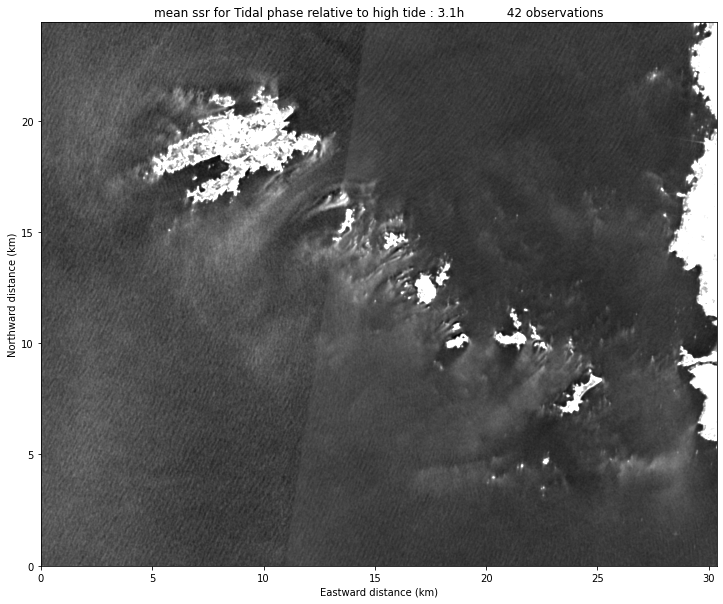

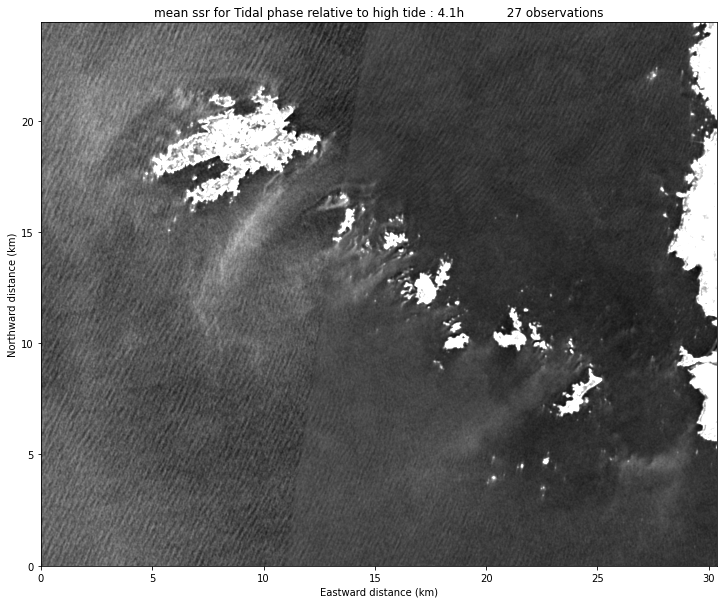

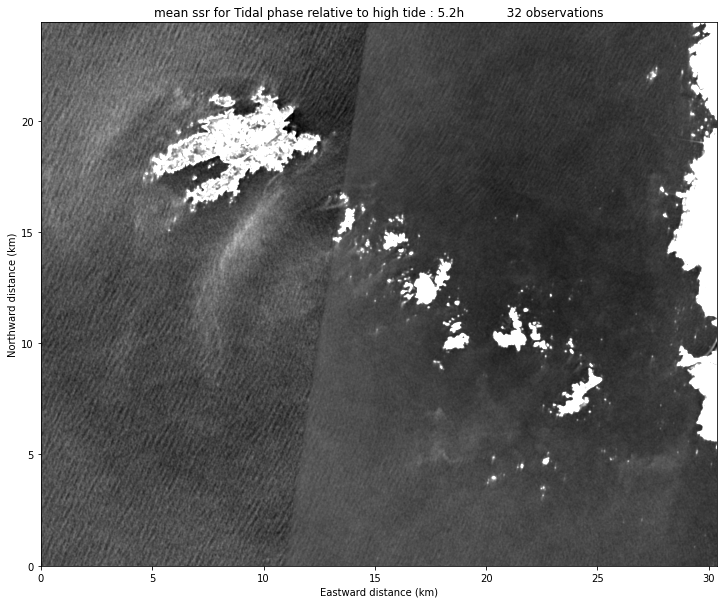

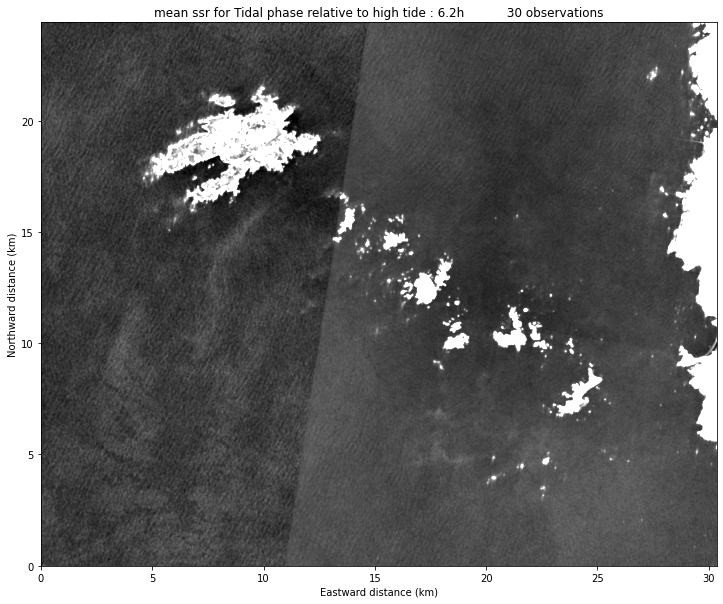

In [7]:
zone = "iroise"
dt = 0
d = 24.42

dirname = '/path to .npy files (iroise_2020.tgz uncrompressed)' 
patt = os.path.join(dirname, '*-2020*.npy')
paths = glob.glob(patt)
t0 = datetime.strptime('17000101t000000', "%Y%m%dt%H%M%S")
i=0
nstep = 12
data = numpy.flipud(np.load(paths[0]))
nx = data.shape[0]
ny = data.shape[1]
ssr = np.zeros((data.shape[0], data.shape[1],nstep))
nv_ssr = np.zeros((data.shape[0], data.shape[1],nstep))
nobs = np.zeros((data.shape[0], data.shape[1],nstep))
for tph in np.linspace(-np.pi,np.pi,num=nstep+1):
    n = 0
    for path in paths:
        bname = os.path.basename(path)
        date = (bname[33:41])
        time = (bname[42:48])
        t = datetime.strptime(bname[35:48], "%y%m%dt%H%M%S")-t0
        wtide = np.argmin(np.abs(tide_time-(t.total_seconds()/3600)))
#         print(tide_time[wtide]-(t.total_seconds()/3600))
#     if ((numpy.int(time) > 0) & (sl[wtide]<-1.0) & (sl[wtide]>-2.0) & (th[wtide]<4.0)) :
        if ((numpy.int(time) < 120000) & (np.abs(np.angle(np.exp(1j*(ph[wtide]-tph))))<(2*np.pi/nstep)) & (amp[wtide]<20) & (abs(tide_time[wtide]-(t.total_seconds()/3600))<1)) :
#             print(amp[wtide])
#             print(bname[35:48])
            data = numpy.flipud(np.load(path))
            data[np.where(data ==255)]=0
            if n == 0 : 
                sigo = data.astype(numpy.float32)
                sigo = sigo/np.median(sigo[np.where((data >10) & (data<250))])
                sigo2 = sigo**2
                count = sigo*0
                count[np.where(data >10)]=1
            else : 
                tmpsigo = data.astype(numpy.float32)
                tmpsigo = tmpsigo/np.median(tmpsigo[np.where((data >10) & (data<250))])
                sigo = sigo + tmpsigo
                sigo2 = sigo2 + tmpsigo**2
                count[np.where(data >10)]= count[np.where(data >10)]+1
            n=n+1
#     print(n)
    if i>0 :
        ssr[:,:,i-1]=numpy.flipud(sigo/count)
        nobs[:,:,i-1]=numpy.flipud(count)
        nv_ssr[:,:,i-1]=numpy.flipud((sigo2/count-(sigo/count)**2)/(sigo/count)**2)
        print(count[500,500])
    fig = plt.figure(figsize=(16,10))
    plt.imshow(numpy.flipud(sigo/count),interpolation='bicubic',cmap='gray',vmin = 0.75,vmax = 1.75,extent=[0,d*sigo.shape[1]/sigo.shape[0],0,d])
#     plt.imshow(numpy.flipud(sigo/count),interpolation='bicubic',cmap='gray',vmin = 80,vmax = 150,extent=[0,d*sigo.shape[1]/sigo.shape[0],0,d])
    plt.xlabel('Eastward distance (km)')
    plt.ylabel('Northward distance (km)')
    plt.title('mean ssr for Tidal phase relative to high tide : '+"{:.1f}".format(tph*12.416/2/np.pi+dt)+'h           '+"{:.0f}".format(n)+' observations')
    plt.savefig('/home/drfab/projets/WOC/theme4/'+zone+'/figs/20220513_'+zone+'_rel_ssr_dsc_tide_phase_'+"{:02d}".format(i)+'_'+"{:.1f}".format(tph*12.416/2/np.pi+dt)+'h.png',dpi=150)
    i = i+1


11.400560224089636


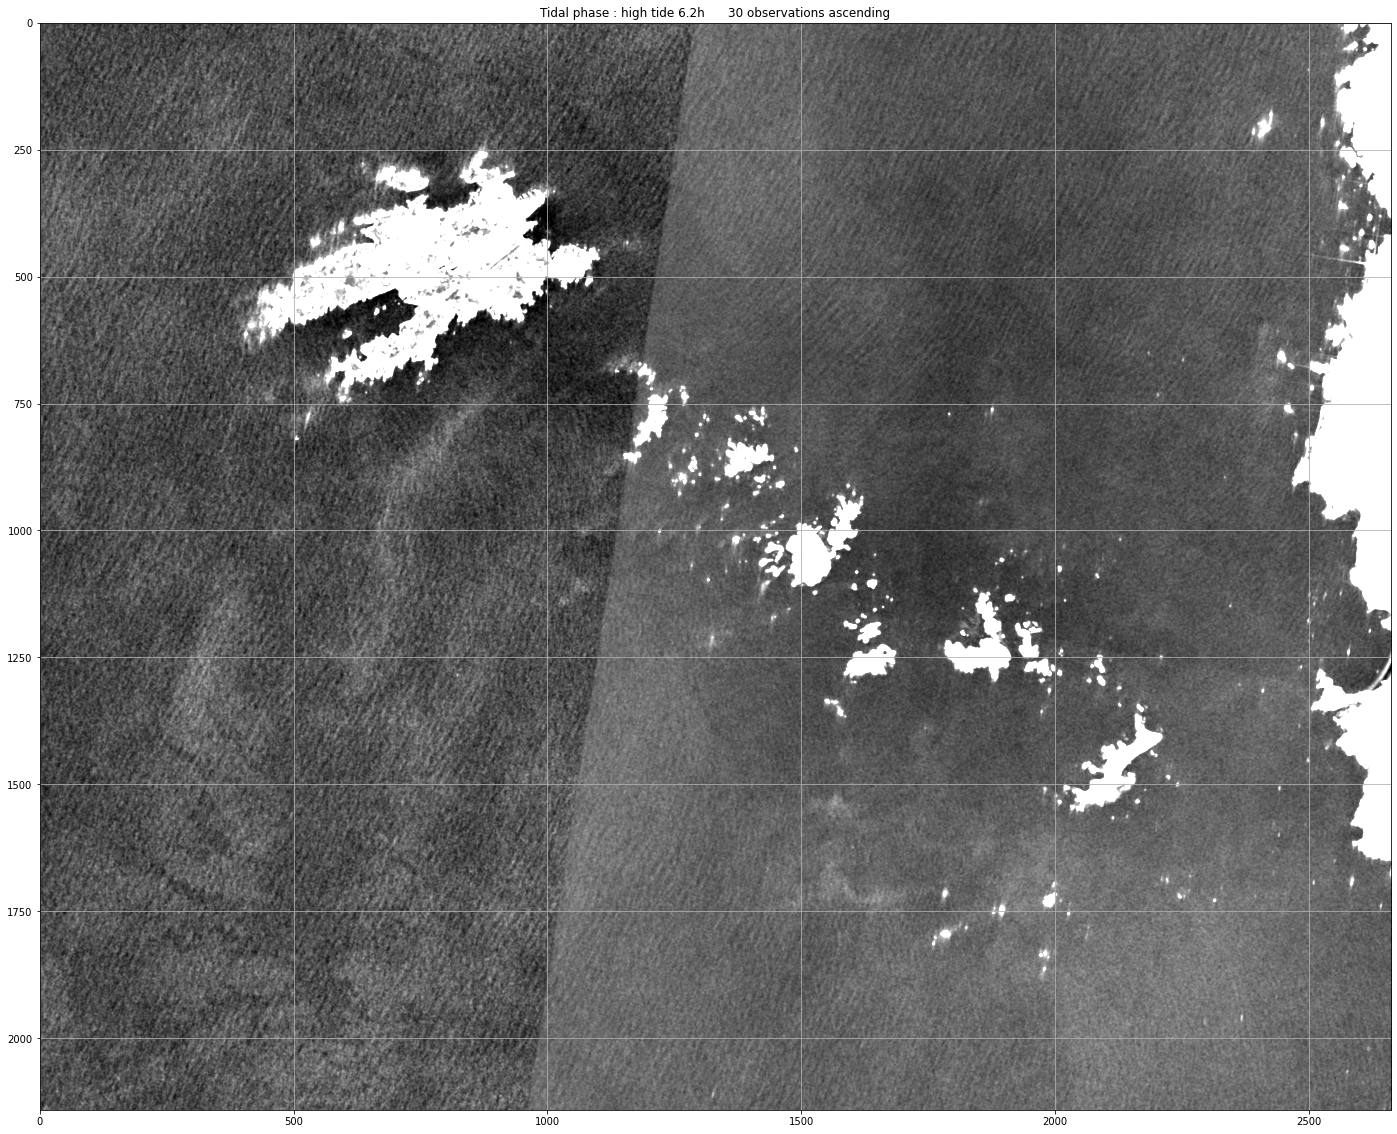

In [9]:
fig = plt.figure(figsize=(26,20))
plt.imshow(numpy.flipud(sigo/count),interpolation='bicubic',cmap='gray',vmin = 0.75,vmax = 1.5)
# plt.imshow(data[:,:],interpolation='bicubic',cmap='gray',vmin = 60,vmax = 160)
# plt.imshow(numpy.flipud(sigo/count),interpolation='bicubic',cmap='gray',vmin = 60,vmax = 160,extent=[0,d*sigo.shape[1]/sigo.shape[0],0,d])
# plt.xlabel('Eastward distance (km)')
# plt.ylabel('Northward distance (km)')
plt.title('Tidal phase : high tide '+"{:.1f}".format(tph*12.416/2/np.pi+dt)+'h      '+"{:0d}".format(n)+' observations ascending')
# plt.xlim([1700,2000])
# plt.ylim([1600,1900])
# plt.ylim([800,200])
# plt.xlim([400,1200])
# plt.ylim([750,650])
# plt.xlim([700,800])
plt.grid()
# cbar=plt.colorbar(shrink=0.85)
ground_spacing = d *1000 / sigo.shape[0]
print(ground_spacing)